# taken from the article

In [23]:
import torch
from torch.distributions.normal import Normal
from torch.nn import Linear, ReLU

def european_option_delta(log_moneyness, time_expiry, volatility):
    s, t, v = map(torch.as_tensor, (log_moneyness, time_expiry, volatility))
    normal = Normal(torch.tensor(0.0), torch.tensor(1.0))
    return normal.cdf((s + (v ** 2 / 2) * t) / (v * torch.sqrt(t)))


def clamp(x, lower, upper):
    x = torch.min(torch.max(x, lower), upper)
    x = torch.where(lower < upper, x, (lower + upper) / 2)
    return x

In [24]:
class MultiLayerPerceptron(torch.nn.ModuleList):
    def __init__(self, in_features, out_features, n_layers=4, n_units=32):
        super().__init__()
        for n in range(n_layers):
            i = in_features if n == 0 else n_units
            self.append(Linear(i, n_units))
            self.append(ReLU())
        self.append(Linear(n_units, out_features))

    def forward(self, x):
        for layer in self:
            x = layer(x)
        return x

In [25]:
class NoTransactionBandNet(torch.nn.Module):


    def __init__(self, in_features=3):
        super().__init__()
        self.mlp = MultiLayerPerceptron(in_features, 2)

    def forward(self, x, prev):
        no_cost_delta = european_option_delta(x[:, 0], x[:, 1], x[:, 2])
        x = x.to(torch.float32)
        band_width = self.mlp(x)
        lower = no_cost_delta - fn.leaky_relu(band_width[:, 0])
        upper = no_cost_delta + fn.leaky_relu(band_width[:, 1])
        
        hedge = clamp(prev, lower, upper)
        # print(no_cost_delta[0], lower[0], upper[0], hedge[0])

        return hedge

In [26]:
class FeedForwardNet(torch.nn.Module):

    def __init__(self, in_features=3):
        super().__init__()

        self.mlp = MultiLayerPerceptron(in_features + 1, 1)

    def forward(self, x, prev):
        no_cost_delta = european_option_delta(x[:, 0], x[:, 1], x[:, 2])
        x = torch.cat((x, prev.reshape(-1, 1)), 1)
        x = x.to(torch.float32)
        x = self.mlp(x).reshape(-1)
        x = torch.tanh(x)
        hedge = no_cost_delta + x 

        return hedge

In [27]:
def generate_geometric_brownian_motion_article(
    n_paths, maturity=30 / 365, dt=1 / 365, volatility=0.2, device=None
) -> torch.Tensor:
 
    randn = torch.randn((int(maturity / dt), n_paths), device=device)
    randn[0, :] = 0.0
    bm = volatility * (dt ** 0.5) * randn.cumsum(0)
    t = torch.linspace(0, maturity, int(maturity / dt))[:, None].to(bm)
    return torch.exp(bm - (volatility ** 2) * t / 2)

# main part

In [28]:
import numpy as np
import torch
import typing

import matplotlib
import matplotlib.pyplot as plt
import plotly.graph_objs as go
import seaborn

import torch.nn.functional as fn
from torch import Tensor
from torch.nn import Module

In [29]:
seaborn.set_style("whitegrid")
torch.manual_seed(42)

if torch.cuda.is_available():
    DEVICE = torch.device('cuda:0')
else: DEVICE = torch.device('cpu')

In [30]:
N_PATHS = 50000
N_EPOCHS = 200

T = 1.0 
dt = T / N_EPOCHS
S0 = 100.0 
mu = 0.05 
sigma = 0.2 

In [31]:
def to_numpy(tensor: torch.Tensor) -> np.array:
    return tensor.cpu().detach().numpy()

In [32]:
def european_option_payoff(prices, strike=1.0):
    return fn.relu(prices[-1, :] - strike)

In [33]:
def generate_geometric_brownian_motion(n_paths: int, n_steps: int, init_state,
                                       sigma: float = 0.2, mu: float = 0.0, dt: float = 1 / 250, r = 0.05, method = "Milstein"):
  torch.manual_seed(123)
  
  if (method == "Milstein"):
      S = torch.zeros(n_paths, n_steps)  
      S[:, 0] = torch.transpose(init_state, 0, 1)

      Z = torch.randn(n_paths, n_steps)
      
      for t in range(1, n_steps):
          S[:, t] = S[:, t-1] + mu*S[:, t-1]*dt + sigma*S[:, t-1]*np.sqrt(dt)*Z[:, t] + 0.5*sigma**2*S[:, t-1]*(Z[:, t]**2-1)*dt

  if (method == "euler"):
      n_steps -= 1
      S = torch.zeros((n_paths, n_steps +1), dtype=torch.float32)
      S[:, 0] = torch.transpose(init_state, 0, 1)

      dW = torch.normal(mean=torch.zeros((n_paths, n_steps)), std=torch.ones((n_paths, n_steps)))
      for t in range(1, n_steps + 1):      
          S[:, t] = S[:, t-1] * np.exp((r - 0.5 * sigma**2) * dt + sigma * np.sqrt(dt) * dW[:, t-1])

  return S

For simulating GBM we will use Milstein method. It is more accurate than Eulers as it takes into account the second-order terms in the stochastic differential equation.

$$Y_{n+1} = Y_n + f(Y_n,t_n)\Delta t + g(Y_n,t_n)\Delta W_n + \frac{1}{2} g(Y_n,t_n) g'(Y_n,t_n)((\Delta W_n)^2 - \Delta t) $$

where $Y_n$ is the approximate solution at time $t_n$, $ \mbox{ }f(Y_n,t_n) \mbox{ }$ and $g(Y_n,t_n) \mbox{ }$ are functions of $Y_n$ and $t_n$, $\Delta t = t_{n+1} - t_n$ is the time step, $\Delta W_n = W_{t_{n+1}} - W_{t_n}$ is the Wiener increment, and $g'(Y_n,t_n)$ is the partial derivative of $g$ with respect to $Y_n$.

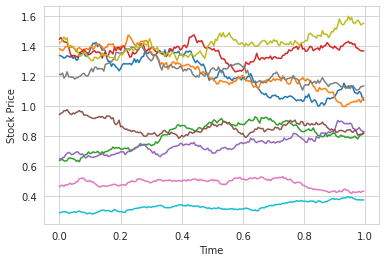

In [34]:
init_s = (10 + (150-10)*torch.rand(N_PATHS, 1))/100
S = generate_geometric_brownian_motion(n_paths = N_PATHS, n_steps = N_EPOCHS, init_state = init_s, method = "Milstein")

plt.plot(torch.arange(0, T, dt), S[:10].T)
plt.xlabel('Time')
plt.ylabel('Stock Price')
plt.show()

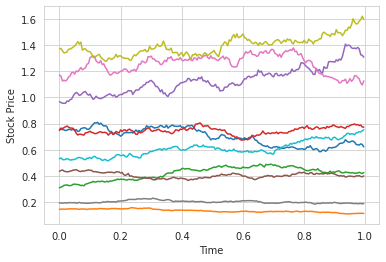

In [35]:
init_s = (10 + (150-10)*torch.rand(N_PATHS, 1))/100
S = generate_geometric_brownian_motion(n_paths = N_PATHS, n_steps = N_EPOCHS, init_state = init_s, method = "euler")

plt.plot(torch.arange(0, T, dt), S[:10].T)
plt.xlabel('Time')
plt.ylabel('Stock Price')
plt.show()

In [36]:
def Heston_simulation(n_paths: int, n_steps: int, init_state, r= 0.05, kappa = 1.5, theta = 0.04, sigma = 0.3, rho = 0.8, dt = 1/ 250):

    S = torch.zeros((n_paths, n_steps+1))
    v = torch.zeros((n_paths, n_steps+1))
    S[:, 0] = torch.transpose(init_state, 0, 1)
    v[:, 0] = theta

    
    dW1 = np.random.normal(size=(n_paths, n_steps))
    dW2 = rho * dW1 + np.sqrt(1 - rho**2) * np.random.normal(size=(n_paths, n_steps))

    for i in range(1, n_steps+1):
        S[:, i] = S[:, i-1] * np.exp((r - 0.5 * v[:, i-1]) * dt + np.sqrt(v[:, i-1] * dt) * dW1[:, i-1])
        v[:, i] = np.maximum(0, v[:, i-1] + kappa * (theta - v[:, i-1]) * dt + sigma * np.sqrt(v[:, i-1] * dt) * dW2[:, i-1])

    return S[:, 1:]

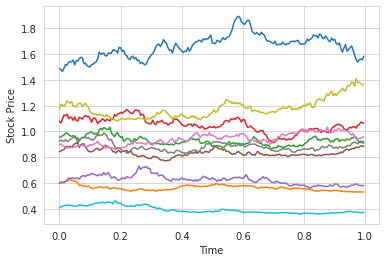

In [37]:
init_s = (10 + (150-10)*torch.rand(N_PATHS, 1))/100
S = Heston_simulation(n_paths = N_PATHS, n_steps = N_EPOCHS, init_state = init_s)

plt.plot(torch.arange(0, T, dt), S[:10].T)
plt.xlabel('Time')
plt.ylabel('Stock Price')
plt.show()

In [38]:
from sklearn.decomposition import PCA

def compute_profit_and_loss(hedging_model, payoff, cost, n_paths = N_PATHS, maturity = 30 / 365, dt = 1 / 365, 
                            volatility = 0.2, r = 0.05, kappa = 1.5, theta = 0.04, sigma = 0.3, rho = 0.8, _n_components = 5):
    # Random init:
    # init_s = (10 + (150-10)*torch.rand(n_paths, 1))/100

    # To set the same init value:
    init_s = torch.full((n_paths, 1), 10, dtype=torch.float32)
    # prices = generate_geometric_brownian_motion(n_paths, n_steps = int (maturity / dt), dt=dt, sigma = volatility, init_state = init_s)
    # prices = prices.T

    # As in the article:
    # prices = generate_geometric_brownian_motion_article(n_paths, maturity=maturity, dt=dt, volatility=volatility, device=DEVICE)

    # Using Heston simulation:
    prices = Heston_simulation(n_paths, n_steps = int (maturity / dt), init_state = init_s, r = r, kappa = kappa, theta = theta, sigma = sigma, rho = rho, dt = dt)
    prices = prices.T

    hedge = torch.zeros_like(prices[:1]).reshape(-1)
    pnl = 0

    pca = PCA(n_components = _n_components)
    pca.fit(prices)
    transformed = torch.tensor(pca.transform(prices))
    prices_pca = torch.tensor(pca.inverse_transform(transformed))
    result_pnl =[]

    for i in [prices, prices_pca]:   
        hedge = torch.zeros_like(i[:1]).reshape(-1)
        pnl = 0
        
        for n in range(i.shape[0] - 1):
            
            x_log_moneyness = i[n, :, None].log()
            x_time_expiry = torch.full_like(x_log_moneyness, maturity - n * dt)
            x_volatility = torch.full_like(x_log_moneyness, volatility)
            x = torch.cat([x_log_moneyness, x_time_expiry, x_volatility], 1)
        
            prev_hedge = hedge
            
            hedge = hedging_model(x, prev_hedge)

            pnl += hedge * (i[n + 1] - i[n])
            pnl -= cost * torch.abs(hedge - prev_hedge) * i[n]

        pnl -= payoff(i)
        result_pnl.append(pnl)
    return result_pnl

In [39]:
model_ntb = NoTransactionBandNet().to(DEVICE)
model_ffn = FeedForwardNet().to(DEVICE)

pnl_ntb, pnl_ntb_pca = compute_profit_and_loss(model_ntb, european_option_payoff, cost=1e-3)
pnl_ffn, pnl_ffn_pca = compute_profit_and_loss(model_ffn, european_option_payoff, cost=1e-3)

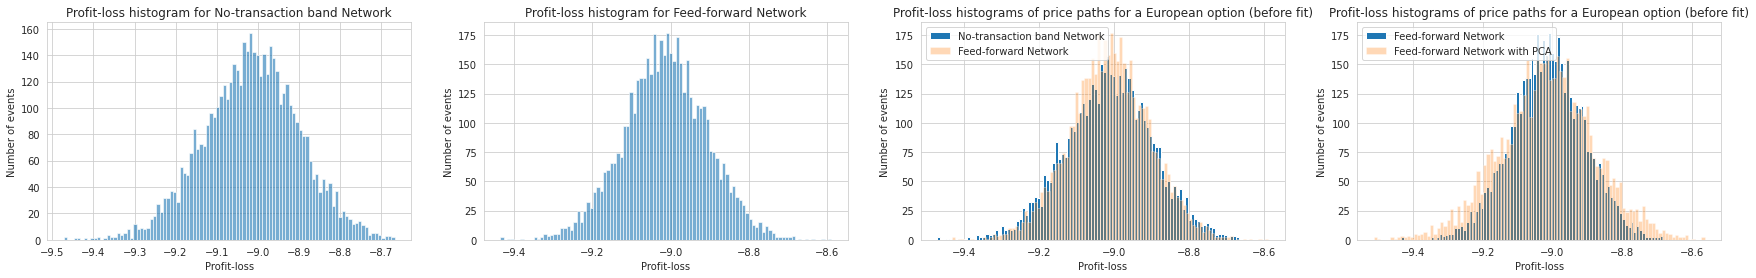

In [40]:
fig, (ax1, ax2, ax3, ax4) = plt.subplots(1, 4, figsize=(30, 4))

ax1.hist(to_numpy(pnl_ntb), bins=100, alpha=0.6, label="No-transaction band Network")
ax1.set_xlabel("Profit-loss")
ax1.set_ylabel("Number of events")
ax1.set_title("Profit-loss histogram for No-transaction band Network")

ax2.hist(to_numpy(pnl_ffn), bins=100, alpha=0.6, label="Feed-forward Network")
ax2.set_xlabel("Profit-loss")
ax2.set_ylabel("Number of events")
ax2.set_title("Profit-loss histogram for Feed-forward Network")

ax3.hist(to_numpy(pnl_ntb), bins=100, label="No-transaction band Network")
ax3.hist(to_numpy(pnl_ffn), bins=100, alpha=0.3, label="Feed-forward Network")
ax3.set_title("Profit-loss histograms of price paths for a European option (before fit)")
ax3.set_xlabel("Profit-loss")
ax3.set_ylabel("Number of events")
ax3.legend()

ax4.hist(to_numpy(pnl_ffn), bins=100, label="Feed-forward Network")
ax4.hist(to_numpy(pnl_ffn_pca), bins=100, alpha=0.3, label="Feed-forward Network with PCA")
ax4.set_title("Profit-loss histograms of price paths for a European option (before fit)")
ax4.set_xlabel("Profit-loss")
ax4.set_ylabel("Number of events")
ax4.legend()

plt.show()


In the article they propose exponential utility $$u(x) = − exp(−λx)$$

In [19]:
from torch.optim import Adam
from tqdm import tqdm


def fit(hedging_model, payoff, cost, n_epochs = N_EPOCHS, lambda_value = 0.1, prog_bar = True):
  
    optim = Adam(hedging_model.parameters())
    optim_pca = Adam(hedging_model.parameters())

    loss_history, loss_history_pca = [], []

    if prog_bar:
        progress = tqdm(range(n_epochs))
    else:
        progress = range(n_epochs)
 
    for _ in progress:
        optim.zero_grad()
        optim_pca.zero_grad()
        pnl, pnl_pca = compute_profit_and_loss(hedging_model, payoff, cost = cost)
        
        loss = torch.mean(-torch.exp(-lambda_value * pnl))
        loss_pca = torch.mean(-torch.exp(-lambda_value * pnl_pca))
        
        loss.backward()
        loss_pca.backward()

        optim.step()
        optim_pca.step()
        if prog_bar:
            progress.desc = f"Loss={loss:.5f}"
        loss_history.append(loss.item())
        loss_history_pca.append(loss_pca.item())

    return [loss_history, loss_history_pca]

In [20]:
torch.manual_seed(42)
history_ntb = fit(model_ntb, european_option_payoff, cost = 1e-3)
torch.manual_seed(42)
history_ffn = fit(model_ffn, european_option_payoff, cost = 1e-3)

Loss=-2.47326: 100%|██████████| 200/200 [13:00<00:00,  3.90s/it]


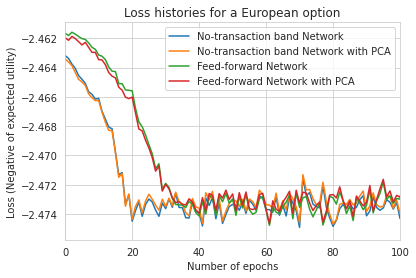

In [22]:
plt.figure()
plt.plot(history_ntb[0], label="No-transaction band Network")
plt.plot(history_ntb[1], label="No-transaction band Network with PCA")
plt.plot(history_ffn[0], label="Feed-forward Network")
plt.plot(history_ffn[1], label="Feed-forward Network with PCA")
plt.xlabel("Number of epochs")
plt.ylabel("Loss (Negative of expected utility)")
plt.title("Loss histories for a European option")
plt.xlim([0, 100])
plt.legend()
plt.show()

In [23]:
torch.manual_seed(42)
pnl_ntb, pnl_ntb_pca = compute_profit_and_loss(model_ntb, european_option_payoff, cost=1e-3)
torch.manual_seed(42)
pnl_ffn, pnl_ffn_pca = compute_profit_and_loss(model_ffn, european_option_payoff, cost=1e-3)

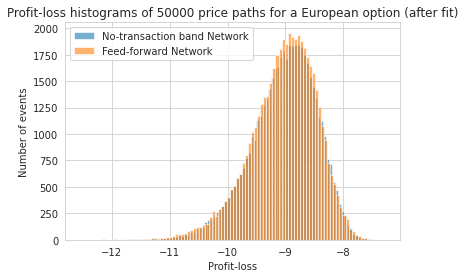

In [24]:
plt.figure()
plt.hist(to_numpy(pnl_ntb), bins=100, alpha=0.6, label="No-transaction band Network")
plt.hist(to_numpy(pnl_ffn), bins=100, alpha=0.6, label="Feed-forward Network")
plt.title("Profit-loss histograms of 50000 price paths for a European option (after fit)")
plt.xlabel("Profit-loss")
plt.ylabel("Number of events")
plt.legend()
plt.show()

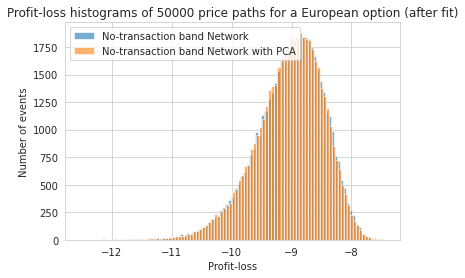

In [26]:
plt.figure()
plt.hist(to_numpy(pnl_ntb), bins=100, alpha=0.6, label="No-transaction band Network")
plt.hist(to_numpy(pnl_ntb_pca), bins=100, alpha=0.6, label="No-transaction band Network with PCA")
plt.title("Profit-loss histograms of 50000 price paths for a European option (after fit)")
plt.xlabel("Profit-loss")
plt.ylabel("Number of events")
plt.legend()
plt.show()

In [21]:
def fit_one_loss(hedging_model, payoff, cost, n_epochs = N_EPOCHS, lambda_value = 0.1, prog_bar = True):
  
    optim = Adam(hedging_model.parameters())
    loss_history = []

    if prog_bar:
        progress = tqdm(range(n_epochs))
    else:
        progress = range(n_epochs)
 
    for _ in progress:
        optim.zero_grad()        
        pnl, pnl_pca = compute_profit_and_loss(hedging_model, payoff, cost = cost)       
        loss = torch.mean(-torch.exp(-lambda_value * pnl))      
        loss.backward()
        optim.step()
        
        if prog_bar:
            progress.desc = f"Loss={loss:.5f}"
        loss_history.append(loss.item())
        

    return loss_history

In [41]:
cost_array = np.linspace(1e-4, 1e-2, 10)
loss = []

for _cost in cost_array:
  history_ntb = fit_one_loss(model_ntb, european_option_payoff, cost = _cost, prog_bar = True)
  loss.append(history_ntb[-1])


Loss=-2.47222: 100%|██████████| 200/200 [01:22<00:00,  2.41it/s]


Something wrong with this plot:

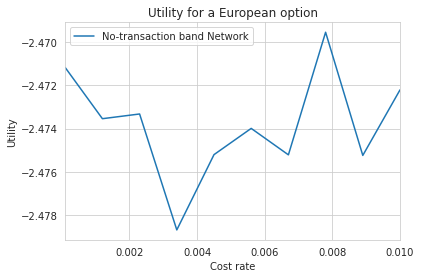

In [42]:
plt.figure()
plt.plot(cost_array, loss, label="No-transaction band Network")

plt.xlabel("Cost rate")
plt.ylabel("Utility")
plt.title("Utility for a European option")
plt.xlim([1e-4, 1e-2])
plt.legend()
plt.show()